# Spaceship Titanic EDA

#### Dataset Background:
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

Original Link: https://www.kaggle.com/competitions/spaceship-titanic/overview

### Column Information
* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("whitegrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

#### Merging the Dataset
Original dataset is split into train and test - but for EDA purposes we need to combine them

In [5]:
test_and_sample = test.merge(sample, on='PassengerId')
spacetitanic = train.merge(test_and_sample, how='outer')

In [6]:
#If merge was succesful we should see nearly 13000 passengers
spacetitanic['PassengerId'].nunique()

12970

#### Peeping the Dataset

In [7]:
spacetitanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Cleaning and Modifying the Data

* Investigate missing values

Amenities:
* NAN for amenities should be replaced with 0
* Combine amenities column and create new column called total spending
* Create category based on number of spending (Broke, Moderate, HeavySpender)

Cryosleep:
* True and False should be replaced with boolean

Passenger ID and Cabin:
* Splitting the passenger ID - Create a new column which consists of a category for solo,couple,three,nuclear,big_group
* Split Cabin into new columns (deck/num/side)

Age:
* Create Age category (Infant, kid, adult, etc.)

## Investigate Missing Values

In [8]:
spacetitanic.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
dtype: int64

## Amenities

In [9]:
#NaN for amenities should be replaced with 0
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spacetitanic[amenities].fillna(0, inplace=True)

In [10]:
#Combine amenities column and create new column called total spending
spacetitanic['total_spending'] = spacetitanic['RoomService'] + spacetitanic['FoodCourt'] + spacetitanic['ShoppingMall'] + spacetitanic['Spa'] + spacetitanic['VRDeck']

Before we can create a category based on number of spending, we should investigate the distribution of the data.

In [11]:
spacetitanic['total_spending'].describe()

count    11607.000000
mean      1470.478677
std       2839.745266
min          0.000000
25%          0.000000
50%        729.000000
75%       1462.500000
max      35987.000000
Name: total_spending, dtype: float64

Coefficient of Variation: Standard deviation divided by Mean

In [12]:
spacetitanic['total_spending'].std() / spacetitanic['total_spending'].mean() 

1.9311706529522992

Since this CV value is greater than 1, it tells us that the standard deviation of the data values are quite high.

To get a better picture, let's take a look at the spread of the data.

In [13]:
spacetitanic['total_spending'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05       0.0
0.25       0.0
0.50     729.0
0.75    1462.5
0.95    6608.0
Name: total_spending, dtype: float64

Boxplot to better visualize the percentile above:

<AxesSubplot:xlabel='total_spending'>

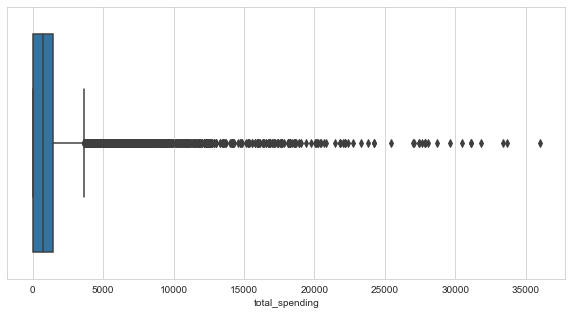

In [14]:
plt.figure(figsize = (10,5))
sns.boxplot(data=spacetitanic, x='total_spending')

Using a histogram to further illustrate the skew and spread:

<AxesSubplot:xlabel='total_spending', ylabel='Count'>

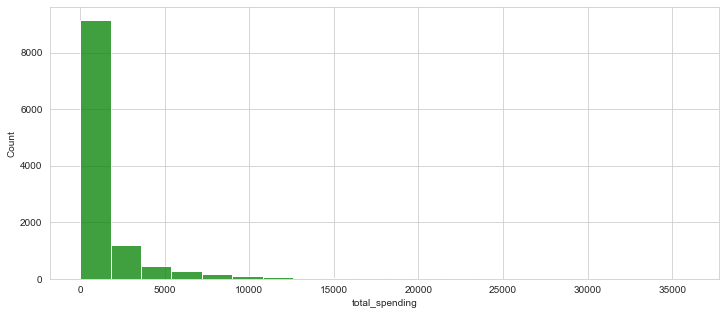

In [15]:
plt.figure(figsize = (12,5))
sns.histplot(data=spacetitanic, x='total_spending', bins=20, color='green')

Alright, it's now very clear that the total spending variable is very much skewed to the left. It is getting increasingly obvious that most of the passengers on the ship don't spend too much cash onboard, if any at all (I suspect the zero spenders are in cryosleep), as opposed to a little minority splashing the cash. 

We should not get into any conclusions though, this is a good starting point because now we can investigate what makes a passenger spend lots of money in the first place. Is it because they are in VIP? Does it have anything to do with age, and so on, and so on.

We will now categorise spending levels based on the quantiles.

In [16]:
def get_spending_cat(x):
    if x == 0:
        return 'zero_spender'
    elif x < 729:
        return 'light_spender'
    elif x < 1463:
        return 'moderate_spender'
    elif x < 6608:
        return 'heavy_spender'
    
spacetitanic['spending_cat'] = spacetitanic['total_spending'].apply(get_spending_cat)

Text(0.5, 1.0, 'Passenger Spending Categories')

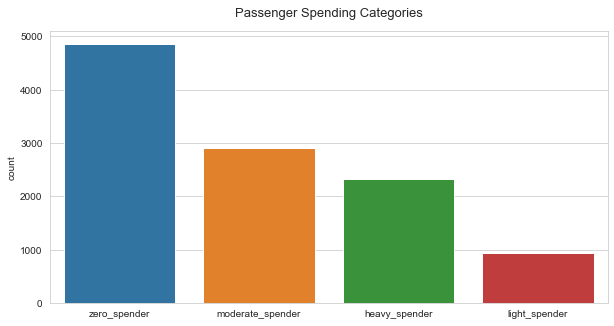

In [17]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data=spacetitanic, x='spending_cat')
ax.set(xlabel= None)
plt.title('Passenger Spending Categories', fontsize = 13, pad = 15)

## Cryo-Sleep Boolean Should Be Converted To Binary

In [18]:
def booleanConvert(x):
    if x == False:
        return 0
    elif x == True:
        return 1
    
spacetitanic['CryoSleepbool'] = spacetitanic['CryoSleep'].apply(booleanConvert)

In [19]:
spacetitanic[['CryoSleep', 'CryoSleepbool']].head(10)

,CryoSleep,CryoSleepbool
0,False,0.0
1,False,0.0
2,False,0.0
3,False,0.0
4,False,0.0
5,False,0.0
6,False,0.0
7,True,1.0
8,False,0.0
9,True,1.0


## Passenger ID and Cabin:
* Split Cabin into new columns (deck/num/side)

In [20]:
spacetitanic[['Deck', 'Num', 'Side']] = spacetitanic['Cabin'].str.split('/', expand=True)

In [34]:
spacetitanic[['Cabin', 'Deck', 'Num', 'Side']].head(7)

,Cabin,Deck,Num,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S
5,F/0/P,F,0,P
6,F/2/S,F,2,S


## Splitting the passenger ID 
* Create a new column which consists of a category for solo,couple,three,nuclear,big_group

In [22]:
spacetitanic['PassengerId'].head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

In [23]:
spacetitanic['Group'] = spacetitanic['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

spacetitanic['Group_size'] = spacetitanic['Group'].apply(lambda x: spacetitanic['Group'].value_counts()[x])

In [39]:
def get_group_cat(group):
    if group == 1:
        return 'solo'
    elif group == 2:
        return 'couple'
    elif group == 3:
        return 'three'
    elif group == 4:
        return 'nuclear'
    else:
        return 'big_group'
    
spacetitanic['Group_cat'] = spacetitanic['Group_size'].apply(get_group_cat)

In [42]:
spacetitanic[['PassengerId', 'Group', 'Group_size', 'Group_cat']].head(7)

,PassengerId,Group,Group_size,Group_cat
0,0001_01,1,1,solo
1,0002_01,2,1,solo
2,0003_01,3,2,couple
3,0003_02,3,2,couple
4,0004_01,4,1,solo
5,0005_01,5,1,solo
6,0006_01,6,2,couple


## Creating an Age Category:

In [25]:
def get_age_group(age):
    if age < 2:
        return 'Infant'
    elif age < 5:
        return 'Toddler'
    elif age < 12:
        return 'Kid'
    elif age < 23:
        return 'Youth'
    elif age < 58:
        return 'Adult'
    else:
        return 'Senior'
    
spacetitanic['Age_group'] = spacetitanic['Age'].apply(get_age_group)

Text(0.5, 1.0, 'Passenger Age Distribution (Categorised)')

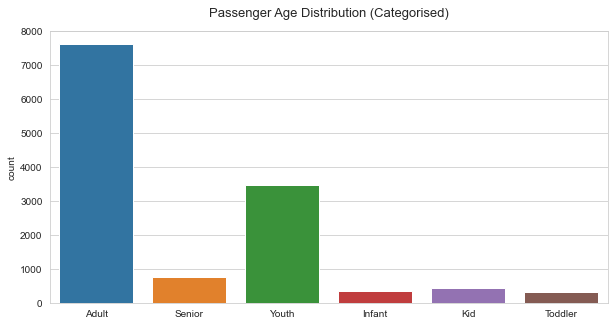

In [26]:
plt.figure(figsize = (10,5))
ax = sns.countplot(data=spacetitanic, x='Age_group')
ax.set(xlabel= None)
plt.title('Passenger Age Distribution (Categorised)', fontsize = 13, pad = 15)

----------------------------------------------------------------------------------------

## Playground

In [27]:
spacetitanic.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'total_spending', 'spending_cat',
       'CryoSleepbool', 'Deck', 'Num', 'Side', 'Group', 'Age_group'],
      dtype='object')